Ideas for this code from:

- https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
- https://towardsdatascience.com/build-interactive-gps-activity-maps-from-gpx-files-using-folium-cf9eebba1fe7

In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWiveLyXQqI4ZN2Y3S9IaqZKFKldwTy33CAcYllaKW9AdML0TnwkflQ



Successfully saved authorization token.


In [3]:
# Import the Folium library.
import folium
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

In [5]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

# Datasets

Import:
- MODIS land cover collection
- MODIS land surface temperature collection
- USGS ground elevation image
- PALSAR forest/non-forest
- SMAP soil moisture
- Precipitation: GPM: Monthly Global Precipitation Measurement (GPM) v6

Dataset references:

Huffman, G.J., E.F. Stocker, D.T. Bolvin, E.J. Nelkin, Jackson Tan (2019), GPM IMERG Final Precipitation L3 1 month 0.1 degree x 0.1 degree V06, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: [Data Access Date], 10.5067/GPM/IMERG/3B-MONTH/06


In [21]:
modis_lc_coll = ee.ImageCollection('MODIS/006/MCD12Q1')
modis_lst_coll = ee.ImageCollection('MODIS/006/MOD11A1')
srtm_elv = ee.Image('USGS/SRTMGL1_003')
palsar_fnf_coll = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF')
smap_sm_coll = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture')
gpm_rain_coll = ee.ImageCollection('NASA/GPM_L3/IMERG_MONTHLY_V06')

Temporal dimension:
- Initial date of interest (inclusive)
- Final date of interest (exclusive)

In [22]:
i_date = '2001-01-01'
f_date = '2020-01-01'


Define location of interest: Highest elevation on track for Mt. Bisoke  

In [23]:
u_lon = 29.48881 
u_lat = -1.461303
u_poi = ee.Geometry.Point(u_lon, u_lat)

Get the data for the pixel intersecting the point...

In [25]:
scale=1000
gpm = gpm_rain_coll.filter(ee.Filter.date(i_date, f_date))
rain_poi = gpm.getRegion(u_poi, scale).getInfo()

# Preview the result.
rain_poi[:5]

rain_df = ee_array_to_df(rain_poi,['precipitation','randomError'])

rain_df.head()

,time,datetime,precipitation,randomError
0,978307200000,2001-01-01,0.175674,0.029737
1,980985600000,2001-02-01,0.093884,0.018825
2,983404800000,2001-03-01,0.177464,0.029977
3,986083200000,2001-04-01,0.192328,0.029424
4,988675200000,2001-05-01,0.156806,0.025681


In [26]:
rain_df['precipitation'].max()

0.39966869354248047

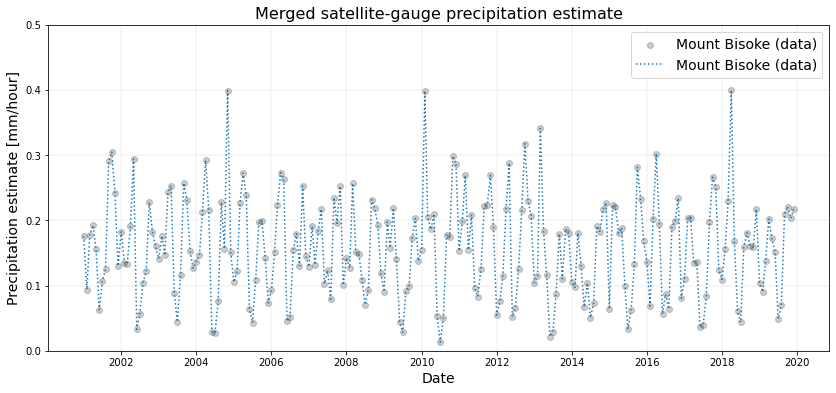

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(rain_df['datetime'], rain_df['precipitation'],
           c='black', alpha=0.2, 
           label='Mount Bisoke (data)')
ax.plot(rain_df['datetime'], rain_df['precipitation'],
           ls=":",label='Mount Bisoke (data)')

ax.set_title('Merged satellite-gauge precipitation estimate', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Precipitation estimate [mm/hour]', fontsize=14)
ax.set_ylim(0, .50)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper right')

plt.show()

In [61]:
# filter collection and select layer
fnf_coll = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF').filterDate('2017-01-01', '2017-12-31');
forestNonForest = fnf_coll.select('fnf').first()
landCover = ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019").select('discrete_classification')

sM_coll = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture').filter(ee.Filter.date('2017-04-01', '2017-04-30'))
soilMoisture = sM_coll.select('ssm').first();

trmm_coll = ee.ImageCollection('TRMM/3B43V7')
precipitation = trmm_coll.filter(ee.Filter.date('2018-04-01', '2018-05-01')).select('precipitation').first()


In [39]:


# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)



In [40]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at selected point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at selected point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at selected point is:', lc_urban_point)

Ground elevation at selected point: 3544 m
Average daytime LST at selected point: 12.95 °C
Land cover value at selected point is: 2


In [42]:
# Get the data for the pixel intersecting the point...
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()
# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  29.487199201223294,
  -1.4597623366942225,
  1483228800000,
  None,
  2],
 ['2017_01_02',
  29.487199201223294,
  -1.4597623366942225,
  1483315200000,
  None,
  2],
 ['2017_01_03',
  29.487199201223294,
  -1.4597623366942225,
  1483401600000,
  None,
  2],
 ['2017_01_04',
  29.487199201223294,
  -1.4597623366942225,
  1483488000000,
  None,
  2]]

In [65]:
# Get the data for the pixel intersecting the point...
trmm = trmm_coll.filter(ee.Filter.date(i_date, f_date))
rain_u_poi = trmm.getRegion(u_poi, scale).getInfo()
# Preview the result.
rain_u_poi[:5]

[['id',
  'longitude',
  'latitude',
  'time',
  'precipitation',
  'relativeError',
  'gaugeRelativeWeighting'],
 ['3B43_20170101_7',
  29.487199201223294,
  -1.4597623366942225,
  1483228800000,
  0.09102392941713333,
  0.04186578840017319,
  64],
 ['3B43_20170201_7',
  29.487199201223294,
  -1.4597623366942225,
  1485907200000,
  0.10739859938621521,
  0.054174426943063736,
  56],
 ['3B43_20170301_7',
  29.487199201223294,
  -1.4597623366942225,
  1488326400000,
  0.18183216452598572,
  0.07187996804714203,
  58],
 ['3B43_20170401_7',
  29.487199201223294,
  -1.4597623366942225,
  1491004800000,
  0.11963226646184921,
  0.058167070150375366,
  55]]

In [46]:
lst_df_pt = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_pt['LST_Day_1km'] = lst_df_pt['LST_Day_1km'].apply(t_modis_to_celsius)


lst_df_pt.head()

,time,datetime,LST_Day_1km
6,1483747200000,2017-01-07,17.65
8,1483920000000,2017-01-09,17.23
11,1484179200000,2017-01-12,15.23
13,1484352000000,2017-01-14,16.73
20,1484956800000,2017-01-21,16.09


In [57]:
# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_pt['time'].apply(float))  # urban
#x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_pt['LST_Day_1km'].apply(float))  # urban
#y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 15
delta_lst = 30
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
#params_r, params_covariance_r = optimize.curve_fit(
#    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])



In [60]:
params_u, phi

(array([ 1.32790785e+01,  2.11893025e+00,  3.11800177e+10, -2.50744125e+00]),
 0.08750554879861981)

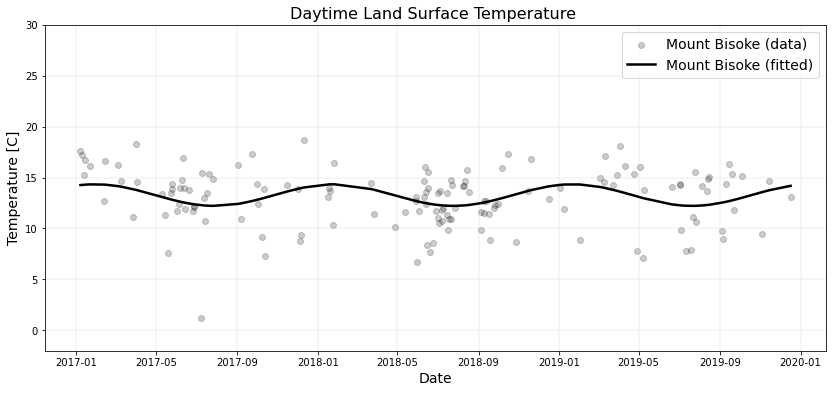

In [56]:
# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_pt['datetime'], lst_df_pt['LST_Day_1km'],
           c='black', alpha=0.2, label='Mount Bisoke (data)')
#ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
#           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_pt['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Mount Bisoke (fitted)', color='black', lw=2.5)
#ax.plot(lst_df_rural['datetime'],
#        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
#        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature ', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-2, 30)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper right')

plt.show()

In [12]:
#evi calculation
def addEVI(image):
    EVI = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR' : image.select('B8').divide(10000),
        'RED' : image.select('B4').divide(10000),
        'BLUE': image.select('B2').divide(10000)}).rename('EVI')
    
    return image.addBands(EVI)


